<a href="https://colab.research.google.com/github/i383993/PRODIGY_GA_04/blob/main/Image_to_Image_Translation_with_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 📌 Step 1: Install dependencies (if needed)
!pip install tensorflow matplotlib pillow --quiet

# 📌 Step 2: Import libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from PIL import Image
import requests
from io import BytesIO
import numpy as np


In [13]:
# 📌 Step 3: Function to download & save image as JPEG
def download_image_as_jpeg(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img.save(save_path, 'JPEG')
        print(f"✅ Saved: {save_path}")
    except Exception as e:
        print(f"❌ Error: {e}")


In [14]:
# 📌 Step 4: Download two sample images
img1_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSSGoQuidvWFsVeY8ZNNVwsuNcLTRNDwn0rCA&s'
img2_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTqAyMf4YfT1MchXtx5oOEd-0ubpQk2ae5hHIvsIkjir-SSNpRC_NPbJEDc7UBG85PEUec&usqp=CAU'

download_image_as_jpeg(img1_url, 'downloaded_image.jpg')
download_image_as_jpeg(img2_url, 'downloaded1_image.jpg')


✅ Saved: downloaded_image.jpg
✅ Saved: downloaded1_image.jpg


In [16]:
# 📌 Step 5: Build Generator (U-Net style)
def build_generator():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    bottleneck = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    bottleneck = layers.ReLU()(bottleneck)
    up1 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(bottleneck)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)
    up2 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up2)
    return tf.keras.Model(inputs, outputs, name="Generator")


In [17]:
# 📌 Step 6: Build Discriminator (PatchGAN style)
def build_discriminator():
    input_img = tf.keras.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same')(input_img)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return tf.keras.Model(input_img, x, name="Discriminator")


In [18]:
# 📌 Step 7: Define Loss Functions
def generator_loss(fake_output, generated_image, target_image):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_image))
    return gan_loss + 100 * l1_loss

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [19]:
# 📌 Step 8: Image Preprocessing
def load_image(path, size=(256, 256)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    return img

def load_dataset(input_path, target_path):
    input_image = load_image(input_path)
    target_image = load_image(target_path)
    return tf.expand_dims(input_image, 0), tf.expand_dims(target_image, 0)


In [26]:
def train_step(input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)
        real_output = discriminator(target_image, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output, generated_image, target_image)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Filter out None gradients
    gen_grads_vars = [(g, v) for g, v in zip(gen_gradients, generator.trainable_variables) if g is not None]
    disc_grads_vars = [(g, v) for g, v in zip(disc_gradients, discriminator.trainable_variables) if g is not None]

    # Apply gradients
    generator_optimizer.apply_gradients(gen_grads_vars)
    discriminator_optimizer.apply_gradients(disc_grads_vars)

    return gen_loss, disc_loss


In [27]:
# 📌 Step 10: Show Output
def generate_and_save_image(model, test_input, target):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Target Image', 'Generated Image']
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()


🧠 Training Pix2Pix model...
Epoch 1 | Gen Loss: 56.9982 | Disc Loss: 2.9494
Epoch 2 | Gen Loss: 61.4237 | Disc Loss: 0.0010
Epoch 3 | Gen Loss: 53.5876 | Disc Loss: 3.2312
Epoch 4 | Gen Loss: 70.1808 | Disc Loss: 0.0000
Epoch 5 | Gen Loss: 64.0349 | Disc Loss: 0.0000


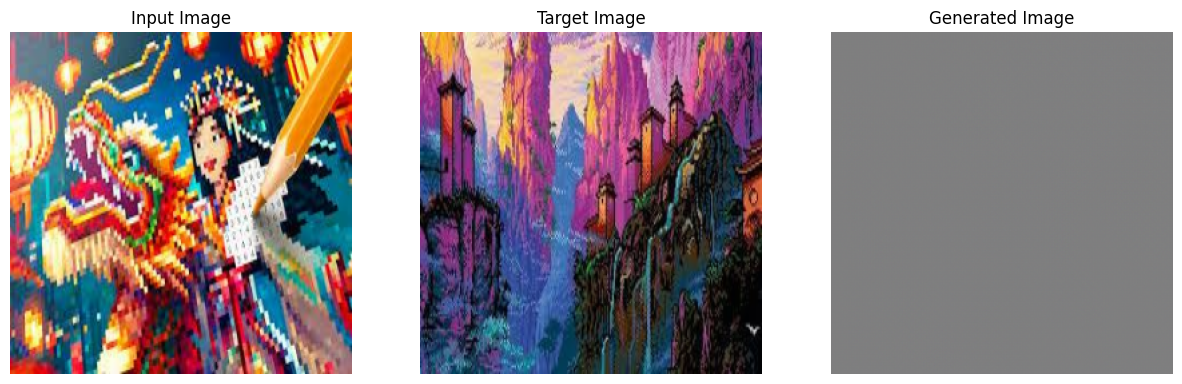

In [28]:

generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

input_image, target_image = load_dataset('downloaded_image.jpg', 'downloaded1_image.jpg')

print("🧠 Training Pix2Pix model...")
for epoch in range(5):
    gen_loss, disc_loss = train_step(input_image, target_image)
    print(f"Epoch {epoch+1} | Gen Loss: {gen_loss:.4f} | Disc Loss: {disc_loss:.4f}")

generate_and_save_image(generator, input_image, target_image)

generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')
